In [3]:
import scipy.io as sio
import torch
from spenpy.spen import spen
import numpy as np
from scipy.io import loadmat
from PIL import Image
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

import matplotlib.pyplot as plt

class physical_model:
    def __init__(self, img_size=(96, 96)):
        self.InvA, self.AFinal = spen(acq_point=img_size).get_InvA()
    
    def __call__(self, x, phase_map=None):
        x = torch.matmul(self.AFinal * 1j, x)
        if phase_map is not None:
            x[:, 1::2, :] *= torch.exp(1j * phase_map)
        return x
    
    def recons(self, x, phase_map=None):
        if phase_map is not None:
            x[:, 1::2, :] *= torch.exp(-1j * phase_map)
        return torch.matmul(self.InvA, x)

def get_demo(data_root="/home/data1/musong/workspace/python/spen-recons/test_data", 
             id="IXI050-Guys-0711-T1_idx0025.mat",
             if_phase_map=False):
    PM = physical_model()
    if(if_phase_map):
        phase_map = sio.loadmat(f"{data_root}/phase_map/{id}")
        phase_map = phase_map[next(reversed(phase_map.keys()))]
        phase_map = torch.tensor(phase_map, dtype=torch.complex64).unsqueeze(0)
    
    data = sio.loadmat(f"{data_root}/hr/{id}")
    data = data[next(reversed(data.keys()))]
    data = data / data.max()
    data = torch.tensor(data, dtype=torch.complex64).unsqueeze(0)
    

    if if_phase_map:
        lr = PM(data, phase_map=phase_map)  
        recons = PM.recons(lr, phase_map=phase_map)
    else:
        lr = PM(data)
        recons = PM.recons(lr)
    
    return data, lr.abs()/lr.abs().max(), recons.abs()/recons.abs().max()

def mat_to_img01(path: str) -> np.ndarray:
    """Load .mat, pick first non-meta key, magnitude if complex, min-max to [0,1], return HxW float32."""
    md = loadmat(path)
    arr = None
    for k, v in md.items():
        if not k.startswith("__"):
            arr = v
            break
    if arr is None:
        raise KeyError(f"No data key found in {path} (only __meta keys).")

    x = np.asarray(arr).squeeze()
    if x.ndim > 2:
        x = x[..., 0]
    if np.iscomplexobj(x):
        x = np.abs(x)
    x = np.nan_to_num(x.astype(np.float32), nan=0.0, posinf=0.0, neginf=0.0)
    xmin, xmax = float(np.min(x)), float(np.max(x))
    if xmax > xmin:
        x = (x - xmin) / (xmax - xmin)
    else:
        x = np.zeros_like(x, dtype=np.float32)
    return x

=== Metrics vs. GT (data_range=1.0) ===
      lr from physical model | PSNR:  16.35 dB | SSIM: 0.4218
  recons from physical model | PSNR:  23.63 dB | SSIM: 0.8562
           recons by pure dl | PSNR:  25.52 dB | SSIM: 0.8918
             recons by pm+dl | PSNR:  26.01 dB | SSIM: 0.8964


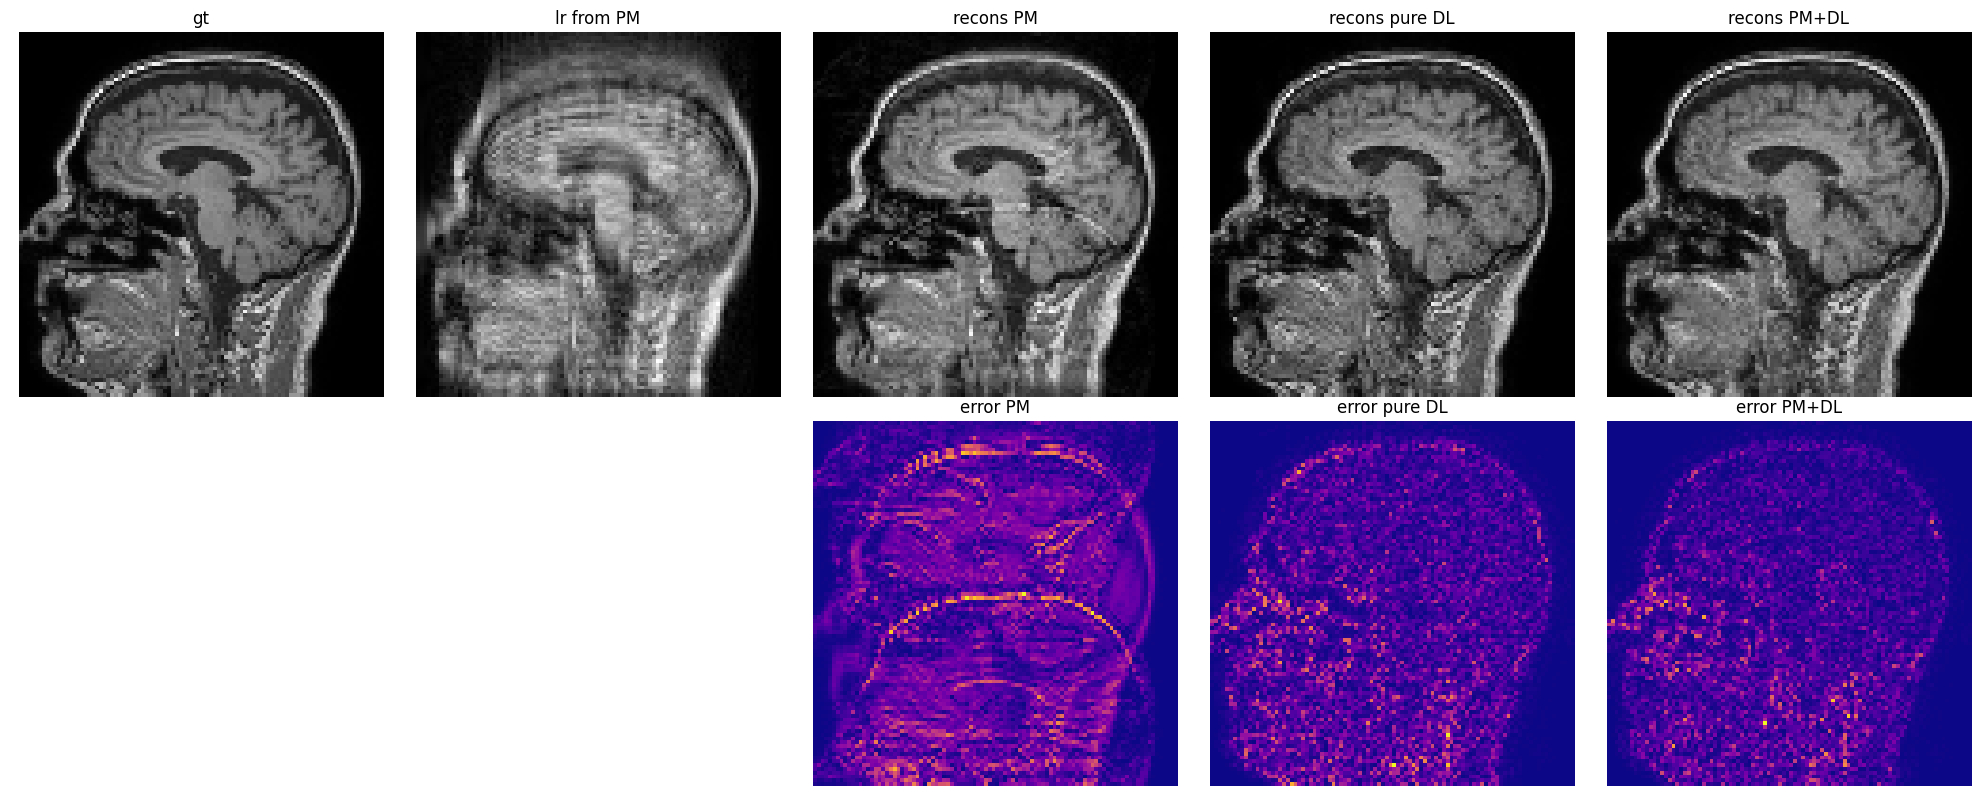

In [4]:
data, lr, recons = get_demo()
recons_path = "/home/data1/musong/workspace/python/spen-recons/log"
recons_id = "IXI050-Guys-0711-T1_idx0025_from_pm_2.png"
recons_1 =  np.array(Image.open(f"{recons_path}/abs_IXI_sim/test/hr/{recons_id}").convert("L"), dtype=np.float32) / 255
recons_2 =  np.array(Image.open(f"{recons_path}/pm_lr/test/hr/{recons_id}").convert("L"), dtype=np.float32) / 255

gt = data[0].real.cpu().numpy()

preds = {
    "lr from physical model":      lr[0].detach().cpu().numpy(),
    "recons from physical model":  recons[0].detach().cpu().numpy(),
    "recons by pure dl":           recons_1,
    "recons by pm+dl":             recons_2,
}


# -------- Metrics --------
print("=== Metrics vs. GT (data_range=1.0) ===")
metrics = {}
for name, pr in preds.items():
    psnr = peak_signal_noise_ratio(gt, pr, data_range=1.0)
    ssim = structural_similarity(gt, pr, data_range=1.0)
    metrics[name] = (psnr, ssim)

    print(f"{name:>28s} | PSNR: {psnr:6.2f} dB | SSIM: {ssim:0.4f}")
    


# Convert to numpy arrays
lr_img      = lr[0].cpu().numpy()
recons_img  = recons[0].cpu().numpy()
recons1_img = np.asarray(recons_1)
recons2_img = np.asarray(recons_2)

# --- Error maps (absolute difference) ---
err_recons  = np.abs(gt - recons_img)
err_recons1 = np.abs(gt - recons1_img)
err_recons2 = np.abs(gt - recons2_img)

fig, axes = plt.subplots(2, 5, figsize=(20, 8))

# Row 1: original comparisons
axes[0,0].imshow(gt, cmap='gray');        axes[0,0].set_title("gt")
axes[0,1].imshow(lr_img, cmap='gray');    axes[0,1].set_title("lr from PM")
axes[0,2].imshow(recons_img, cmap='gray');axes[0,2].set_title("recons PM")
axes[0,3].imshow(recons1_img, cmap='gray');axes[0,3].set_title("recons pure DL")
axes[0,4].imshow(recons2_img, cmap='gray');axes[0,4].set_title("recons PM+DL")

# Row 2: error maps (jet colormap)
axes[1,0].axis("off")  # empty under GT
axes[1,1].axis("off")  # empty under LR
im1 = axes[1,2].imshow(err_recons, cmap='plasma');   axes[1,2].set_title("error PM")
im2 = axes[1,3].imshow(err_recons1, cmap='plasma');  axes[1,3].set_title("error pure DL")
im3 = axes[1,4].imshow(err_recons2, cmap='plasma');  axes[1,4].set_title("error PM+DL")


for axrow in axes:
    for ax in axrow:
        ax.axis("off")

plt.tight_layout()
plt.savefig('1.png', dpi=300)
plt.show()


=== Metrics vs. GT (data_range=1.0) ===
 lr_real from physical model | PSNR:  16.72 dB | SSIM: 0.4750
  recons from physical model | PSNR:  23.63 dB | SSIM: 0.8562
           recons by pure dl | PSNR:  26.44 dB | SSIM: 0.9141
             recons by pm+dl | PSNR:  25.83 dB | SSIM: 0.8928


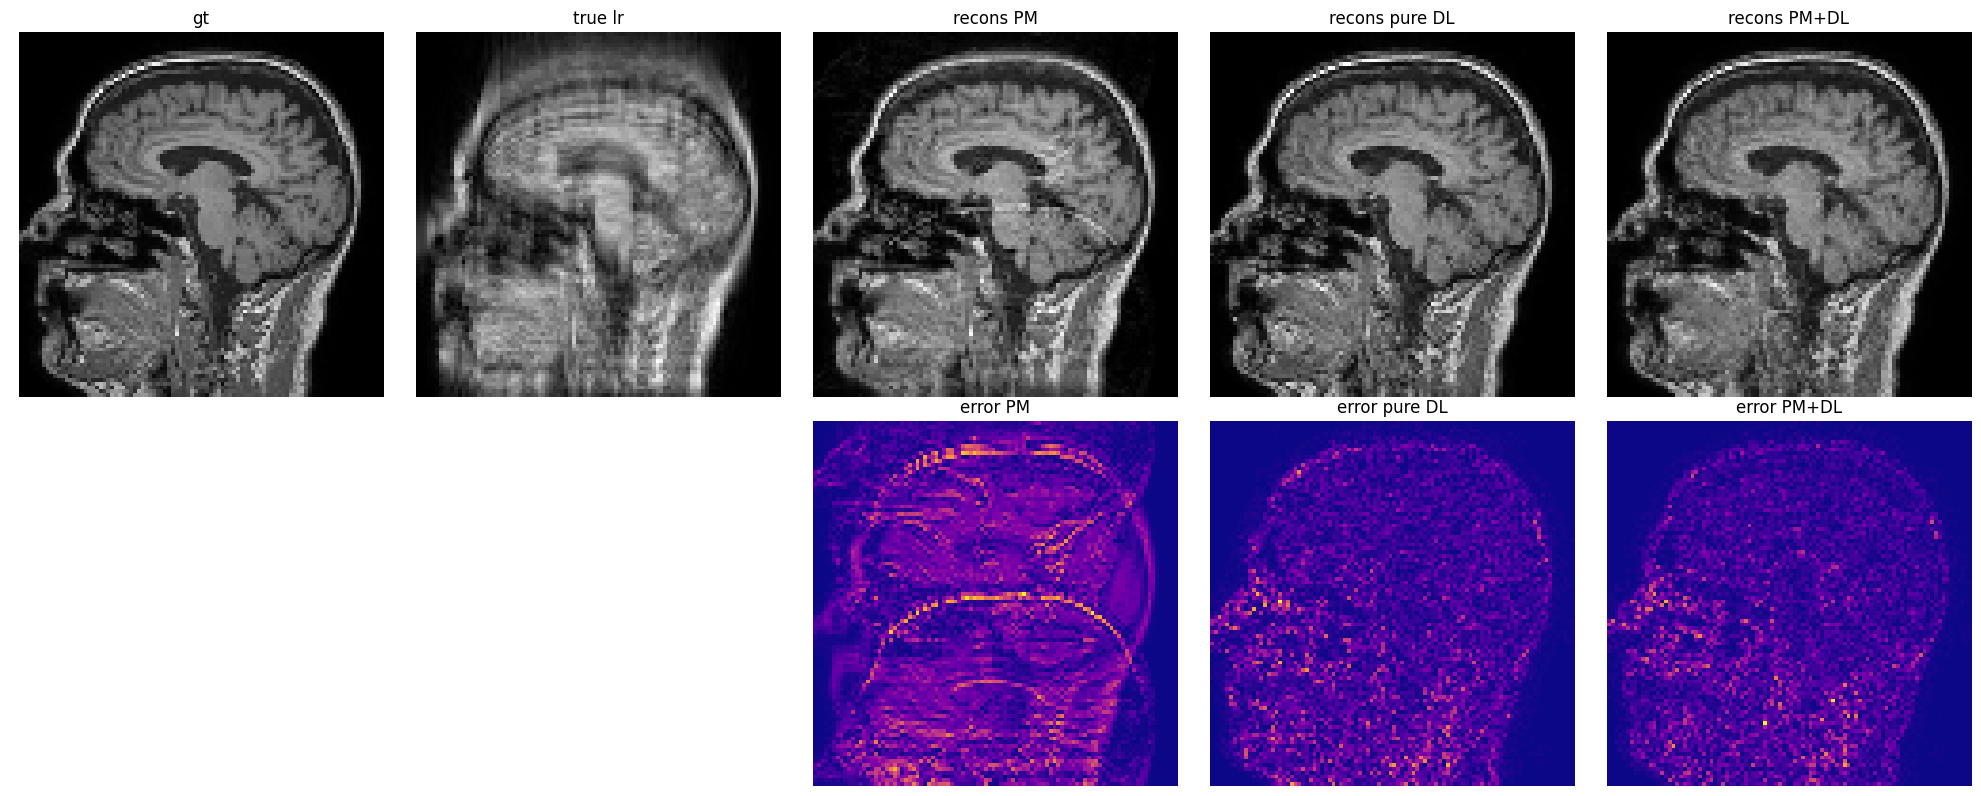

In [5]:
data, lr_real, recons = get_demo()
lr_real = mat_to_img01("/home/data1/musong/workspace/python/spen-recons/test_data/lr/IXI050-Guys-0711-T1_idx0025.mat")
recons_path = "/home/data1/musong/workspace/python/spen-recons/log"
recons_id = "IXI050-Guys-0711-T1_idx0025_1.png"
recons_1 =  np.array(Image.open(f"{recons_path}/abs_IXI_sim/test/hr/{recons_id}").convert("L"), dtype=np.float32) / 255
recons_2 =  np.array(Image.open(f"{recons_path}/pm_lr/test/hr/{recons_id}").convert("L"), dtype=np.float32) / 255

gt = data[0].real.cpu().numpy()

preds = {
    "lr_real from physical model":      np.abs(lr_real),
    "recons from physical model":  recons[0].detach().cpu().numpy(),
    "recons by pure dl":           recons_1,
    "recons by pm+dl":             recons_2,
}


# -------- Metrics --------
print("=== Metrics vs. GT (data_range=1.0) ===")
metrics = {}
for name, pr in preds.items():
    psnr = peak_signal_noise_ratio(gt, pr, data_range=1.0)
    ssim = structural_similarity(gt, pr, data_range=1.0)
    metrics[name] = (psnr, ssim)

    print(f"{name:>28s} | PSNR: {psnr:6.2f} dB | SSIM: {ssim:0.4f}")
    


# Convert to numpy arrays
lr_img      = np.abs(lr_real)
recons_img  = recons[0].cpu().numpy()
recons1_img = np.asarray(recons_1)
recons2_img = np.asarray(recons_2)

# --- Error maps (absolute difference) ---
err_recons  = np.abs(gt - recons_img)
err_recons1 = np.abs(gt - recons1_img)
err_recons2 = np.abs(gt - recons2_img)

fig, axes = plt.subplots(2, 5, figsize=(20, 8))

# Row 1: original comparisons
axes[0,0].imshow(gt, cmap='gray');        axes[0,0].set_title("gt")
axes[0,1].imshow(lr_img, cmap='gray');    axes[0,1].set_title("true lr")
axes[0,2].imshow(recons_img, cmap='gray');axes[0,2].set_title("recons PM")
axes[0,3].imshow(recons1_img, cmap='gray');axes[0,3].set_title("recons pure DL")
axes[0,4].imshow(recons2_img, cmap='gray');axes[0,4].set_title("recons PM+DL")

# Row 2: error maps (jet colormap)
axes[1,0].axis("off")  # empty under GT
axes[1,1].axis("off")  # empty under LR
im1 = axes[1,2].imshow(err_recons, cmap='plasma');   axes[1,2].set_title("error PM")
im2 = axes[1,3].imshow(err_recons1, cmap='plasma');  axes[1,3].set_title("error pure DL")
im3 = axes[1,4].imshow(err_recons2, cmap='plasma');  axes[1,4].set_title("error PM+DL")


for axrow in axes:
    for ax in axrow:
        ax.axis("off")

plt.tight_layout()
plt.savefig('2.png', dpi=300)
plt.show()

lr from PM vs. true lr | PSNR:  33.38 dB | SSIM: 0.9517


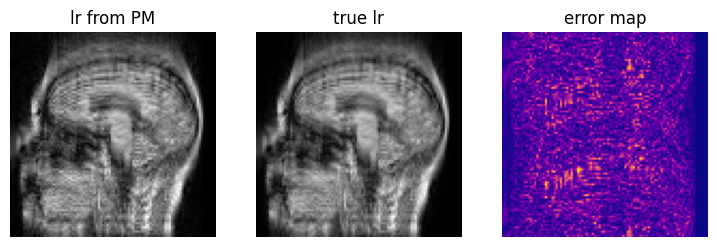

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(9, 3))


axes[0].imshow(lr.numpy()[0], cmap='gray');axes[0].set_title("lr from PM");axes[0].axis("off")
axes[1].imshow(lr_real, cmap='gray');axes[1].set_title("true lr");axes[1].axis("off")
axes[2].imshow(np.abs(lr.numpy()[0] - lr_real), cmap='plasma');axes[2].set_title("error map");axes[2].axis("off")
plt.savefig('3.png', dpi=300)

psnr = peak_signal_noise_ratio(lr.numpy()[0], lr_real, data_range=1.0)
ssim = structural_similarity(lr.numpy()[0], lr_real, data_range=1.0)

print(f"lr from PM vs. true lr | PSNR: {psnr:6.2f} dB | SSIM: {ssim:0.4f}")